### LangGraph 多智能体协作中文指南

在单个领域中，通常一个智能体能够有效地使用一些工具，但即使是使用强大的模型（例如 GPT-4），它在使用大量工具时效果可能会有所降低。

一种解决复杂任务的方法是采用“分而治之”的方式：为每个任务或领域创建一个专门的智能体，并将任务路由到正确的“专家”。

本指南灵感来自 Wu 等人的论文《AutoGen: 通过多智能体对话实现下一代 LLM 应用》 展示了使用 LangGraph 进行多智能体协作的一种方法。

### 工作流程概述

工作流程清晰地展示了多智能体协作的核心步骤，便于理解 LangGraph 的实现方法。

1. **定义工具**：为每个智能体提供专用的工具，例如 Tavily 搜索工具和 Python REPL 工具，用于执行特定任务。
2. **定义辅助函数：agent_node**：将每个智能体与对应任务进行关联，定义图中的智能体节点，使其能够处理特定任务。
3. **定义辅助函数：create_agent**：为每个任务创建独立的智能体，例如研究智能体、图表生成器智能体等。每个智能体使用独立的语言模型和工具。
4. **定义研究智能体及节点: Researcher**: 研究智能体使用 Tavily 搜索工具，回应用户提问。
5. **定义图表生成器智能体及节点: Chart_Generator**: 根据提供的数据，在沙盒环境执行 Python 代码生成图表。
6. **导入预构建的工具节点: ToolNode**: 将2中定义的 Tavily 搜索工具和 Python REPL 工具作为一个工具节点，这样可以方便地在工作流中使用这些工具。
7. **建立智能体节点间通信: AgentState**：通过 LangGraph 实现智能体间通信，智能体能够共享状态并相互协作完成复杂任务。
8. **定义工作流（状态图)**：创建状态图以管理多智能体协作的流程，包含任务路由和边逻辑，确保正确的智能体按顺序执行。
9. **执行工作流**：根据状态图执行多智能体任务，通过工具调用和智能体协作，完成目标任务并生成最终输出。

最终的工作流执行时应像下图所示：

![simple_multi_agent_diagram](./images/simple_multi_agent_diagram.png)


In [1]:
%%capture --no-stderr
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"



### 1. 定义工具

接下来我们定义一些未来智能体将使用的工具。

#### 注释说明：
- `tavily_tool`: 定义了一个 Tavily 搜索工具，可以搜索最多 5 条结果。
- `repl`: 定义了一个 Python REPL 工具，用于执行 Python 代码块。
- `python_repl` 函数：这是一个装饰的工具函数，接受 Python 代码作为输入，并通过 `PythonREPL` 环境执行代码。成功执行后返回执行的代码和输出。如果发生错误，则捕获并返回错误信息。


In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 搜索工具，用于搜索
tavily_tool = TavilySearchResults(max_results=5)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"


    return f"Successfully executed:\n```python\n{code}\n```\n"

        
    # result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    
    # return (
    #     result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    # )

-----------

### 2. 辅助函数：智能体节点

下面我们定义智能体节点函数（`agent_node`)，然后使用它分别定义2个智能体节点：
- Researcher
- Chart_Generator

#### 注释说明：

- `agent_node` 函数是一个辅助函数，用于创建一个智能体节点。它接受当前的 `state`（状态）、`agent`（智能体） 和 `name`（智能体的名称），并返回一个新的状态字典，包含消息和发送者。
- `research_agent`: 使用 `create_agent` 函数创建了一个研究智能体，使用 `research_llm` 作为语言模型，并且绑定了 `tavily_tool` 搜索工具。
- `chart_agent`: 同样使用 `create_agent` 创建了图表生成器智能体，使用 `chart_llm` 作为语言模型，并绑定了 `python_repl` 代码执行工具。
- `functools.partial`: 用于创建特定名称的智能体节点，例如 `"Researcher"` 和 `"Chart_Generator"`，并与各自的智能体绑定。

In [4]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 修正名称格式，移除空格并确保只包含合法字符
    name = name.replace(" ", "_").replace("-", "_")  # 确保符合正则表达式要求

    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }

#### 关于 `AIMessage` 构造

`AIMessage` 是 LangChain 中用于表示 AI 模型回复的类，它封装了 AI 生成的文本或内容。为了让 Python 初学者更好地理解，我们可以从以下几个方面详细说明 `AIMessage` 的构造方法及其相关概念。

##### `AIMessage` 构造方法简介

在代码中，`AIMessage(**result.dict(exclude={"type", "name"}), name=name)` 这段代码使用了 `AIMessage` 的构造方法。`AIMessage` 的目的是将 AI 生成的消息封装起来，方便后续处理和传递。这里的构造方法通过传递字典参数创建 `AIMessage` 对象。

##### `AIMessage` 类的常见构造参数：
- **content**: 这是消息的主要部分，通常是 AI 模型生成的文本内容。例如，一个简单的对话模型可能会生成一个包含回答问题的字符串。
- **name**: 可选参数，用于标识发送消息的 AI 模型或智能体的名称。在你的代码中，`name=name` 表示为智能体分配一个名称（如 `"Researcher"` 或 `"Chart_Generator"`），以便在不同智能体之间进行区分。
- **additional_metadata**: 有时候，消息不仅仅包含文本内容，还可能附加其他元数据，如调用的工具、时间戳等。

##### 深入理解构造方法中的步骤：

1. **`result.dict()`**: 
   这一部分将 `result` 对象转换为字典。字典是一种键值对的结构，便于存储和管理数据。Python 中的 `dict()` 方法会把 `result` 对象的所有属性转换成字典的形式，方便在构造 `AIMessage` 时传递这些数据。

2. **`exclude={"type", "name"}`**:
   在构造 `AIMessage` 时，使用了 `exclude` 参数来排除某些不必要的字段。`type` 和 `name` 这两个字段不会被传递给 `AIMessage`，这是因为它们可能不是 AI 消息本身的必要部分或已经在其他地方定义过。

3. **`name=name`**:
   这里的 `name` 参数表示智能体的名称，它是在 `agent_node` 函数中作为参数传递的。在构造 `AIMessage` 时，通过这个参数来标识消息的来源智能体是谁，比如 `"Researcher"` 或 `"Chart_Generator"`。


### 3. 辅助函数：创建智能体

以下助手函数将帮助我们创建智能体。这些智能体将成为图中的节点。

#### 注释说明：
- 该函数 `create_agent` 用于创建一个智能体，通过为该智能体提供系统消息和可以使用的工具来指定其行为。
- `ChatPromptTemplate.from_messages` 是用于构建该智能体的对话提示模板，系统消息告诉智能体它是如何与其他智能体协作的。
- 提示模板通过 `partial` 函数插入了系统消息和工具名称，使得智能体能够根据提供的工具执行任务。
- 最终，智能体被绑定到所提供的 LLM（大型语言模型）和工具列表中，构成一个完整的智能体逻辑。


In [5]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, tool_message: str, custom_notice: str=""):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                "\n{custom_notice}\n"
                " You have access to the following tools: {tool_names}.\n{tool_message}\n\n",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符

        ]
    )

    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(tool_message=tool_message, custom_notice=custom_notice)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
      
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)



#### `partial` 是什么

在 Python 中，`partial` 方法是 `functools` 模块中的一个功能，它用于创建一个**新的函数**，这个函数是基于原函数的**部分参数已经固定**的版本。这在需要重复调用同一函数，并且传递相同的某些参数时非常有用。

####  `partial` 的基本理解

通过 `partial`，我们可以预先为函数的某些参数赋值，生成一个新的函数，这个新函数已经预先固定了部分参数，只需要再传递剩下的参数即可。

#### `prompt.partial` 解析

这里的 `partial` 用于创建一个新的提示模板对象，并为 `system_message` 和 `tool_names` 这两个参数提供了值。这相当于对提示模板的“定制”，预先指定了这些参数的值。

**`partial` 的具体作用：**

1. 调用 `prompt.partial(system_message=system_message)`，预先为 `system_message` 参数赋值，生成一个新的提示模板，固定了系统消息的内容。
2. 调用 `prompt.partial(tool_names=", ".join([tool.name for tool in tools]))`，为 `tool_names` 参数赋值，将所有工具的名称合并成一个字符串，并固定在新的模板中。

通过这两步 `partial` 调用，`prompt` 对象中已经预先填入了 `system_message` 和 `tool_names` 这两个参数，简化了后续的调用过程。

--------------------

--------------

### 4. 定义 研究智能体及其节点


In [6]:
# 为 Agent 配置各自的大模型
research_llm = ChatOpenAI(model="gpt-4o-mini")
chart_llm = ChatOpenAI(model="gpt-4o-mini")

In [7]:
# 研究智能体及其节点
research_agent = create_agent(
    research_llm,  # 使用 research_llm 作为研究智能体的语言模型
    [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
    tool_message=(
        "Before using the search engine, carefully think through and clarify the query."
        " Then, conduct a single search that addresses all aspects of the query in one go",
    ),
    custom_notice=(
        "Notice:\n"
        "Only gather and organize information. Do not generate code or give final conclusions, leave that for other assistants."
    ),
)

In [8]:
# 使用 functools.partial 创建研究智能体的节点，指定该节点的名称为 "Researcher"
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

这里的 `functools.partial` 创建了一个新的函数 `research_node`，该函数基于原始的 `agent_node` 函数，且已经为 `agent_node` 的部分参数（`agent` 和 `name`）预先设置了值。新的 `research_node` 函数只需要接收剩余的参数就可以正常运行。


**`partial` 的具体作用：**

1. **原始函数 `agent_node`**：
   ```python
   def agent_node(state, agent, name):
       # 函数体...
   ```
   - `agent_node` 是一个接受 `state`, `agent`, 和 `name` 三个参数的函数。

2. **使用 `functools.partial`**：
   ```python
   research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
   ```
   - 通过 `functools.partial`，我们创建了一个新的函数 `research_node`，它仍然是 `agent_node`，但 `agent` 参数和 `name` 参数已经被预先固定：
     - `agent=research_agent`
     - `name="Researcher"`
   - 也就是说，调用 `research_node` 时，只需要传递 `state` 参数，因为 `agent` 和 `name` 已经有默认值了。

**举个例子**

假设有一个函数 `agent_node`，你经常需要调用它并传递相同的 `agent` 和 `name`，那么每次调用时重复写这些参数会很冗余。使用 `partial` 可以避免这种重复。

```python
# 原始函数定义
def agent_node(state, agent, name):
    print(f"State: {state}, Agent: {agent}, Name: {name}")

# 预先设置 agent 和 name 参数
research_node = functools.partial(agent_node, agent="research_agent_value", name="Researcher")

# 调用时只需要传递剩下的参数
research_node(state="current_state")
# 输出: State: current_state, Agent: research_agent_value, Name: Researcher
```

#### `functools.partial` 的优势

1. **减少重复代码**：在你需要多次调用同一个函数并且某些参数不变时，`partial` 可以避免每次都传递相同的参数。
   
2. **简化函数调用**：在需要频繁使用相同参数时，`partial` 提供了更简洁的写法，使代码更易于维护。

#### 总结

在这段代码中，`functools.partial` 的用法预先为 `agent_node` 函数的部分参数（`agent` 和 `name`）赋值，创建了一个新函数 `research_node`。调用 `research_node` 时，只需要传递剩下的参数（`state`），从而简化了函数调用的流程。

------------------

### 5. 定义 图表生成器智能体及其节点

In [9]:
chart_agent = create_agent(
    chart_llm,  # 使用 chart_llm 作为图表生成器智能体的语言模型
    [python_repl],  # 图表生成器智能体使用 Python REPL 工具
    tool_message="Create clear and user-friendly charts based on the provided data.",  # 系统消息，指导智能体如何生成图表
    custom_notice="Notice:\n"
    "If you have completed all tasks, respond with FINAL ANSWER.",
)

In [10]:
# 使用 functools.partial 创建图表生成器智能体的节点，指定该节点的名称为 "Chart_Generator"
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")


### 6. 导入预构建的工具节点

我们现在导入预构建的工具节点 `ToolNode` （运行上一个AIMessage中调用工具的节点。）。将 Tavily 搜索工具和 Python REPL 工具作为一个工具节点，这样可以方便地在工作流中使用这些工具。

### 什么是 ToolNode？

**ToolNode** 是 LangChain 的一个预构建节点，它能够从图状态（`graph state`）中提取消息并调用指定的工具，最后将工具调用的结果反馈回图的状态中。ToolNode 非常适合与 LangGraph 中的 ReAct agent 协同工作，但也可以与任何 `StateGraph` 配合使用，只要状态中有 `messages` 键和合适的消息处理方式。

#### ToolNode 的特点
1. **工具调用**：ToolNode 可以根据状态中的消息自动调用指定的工具，并返回工具的执行结果。
2. **兼容性**：可以与任意支持工具调用的 LangChain 模型配合使用。
3. **并行工具调用**：支持同时调用多个工具，并处理工具返回的多个结果。
4. **错误处理**：ToolNode 默认启用了错误处理，可以处理工具在执行过程中的异常情况。

#### 与对话模型结合使用

在使用像 Anthropic 这样的对话模型时，模型可以自动生成带有 `tool_calls` 的 `AIMessage`，这样我们可以直接将模型生成的消息传给 ToolNode 来执行工具调用：

```python
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import ToolNode

model_with_tools = ChatAnthropic(
    model="claude-3-haiku-20240307", temperature=0
).bind_tools(tools)

tool_node.invoke({"messages": [model_with_tools.invoke("what's the weather in sf?")]})
# 返回: {'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='toolu_01LFvAVT3xJMeZS6kbWwBGZK')]}
```

#### ToolNode 与 ReAct Agent 结合

ReAct Agent 是 LangGraph 中的一种智能体，它会反复调用工具，直到收集到足够的信息来解决问题。以下是 ReAct Agent 的基本工作流，它通过工具节点来完成工具调用：

```python
from typing import Literal
from langgraph.graph import StateGraph, MessagesState

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

# 创建状态图
workflow = StateGraph(MessagesState)

# 定义两个节点：一个用于调用模型，一个用于调用工具
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")  # 从 agent 节点开始
workflow.add_conditional_edges("agent", should_continue)  # 根据条件判断是否继续调用工具
workflow.add_edge("tools", "agent")  # 工具调用完成后，返回 agent 节点

app = workflow.compile()  # 编译状态图
```

#### 错误处理

ToolNode 默认启用了错误处理，可以处理工具执行中的异常情况。如果想禁用错误处理，可以设置 `handle_tool_errors=False`。

#### 总结

**ToolNode** 是一个非常强大的组件，它能够自动调用工具并将结果反馈回工作流。它可以处理单个或多个工具调用，并与 LangChain 模型紧密结合，使得在复杂的多步骤任务中能够更高效地调用外部 API 或工具。

In [11]:
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)

------------------------


### 7. 建立智能体节点间通信 AgentState

定义智能体节点和工具节点后，接下来需要在 Graph 中使它们互相通信。

因此，我们需要定义节点间的消息传递数据结构：AgentState

我们使用一个消息列表，并包含一个键来跟踪最近的发送者。

#### 注释说明：
- `AgentState` 是一个 `TypedDict`，它定义了图中传递的状态对象，包括 `messages` 和 `sender`。`messages` 用于存储传递的消息，`sender` 用于跟踪消息的发送者。


In [12]:
import operator
from typing import Annotated, Sequence, TypedDict

# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str


### 8. 定义工作流（状态图）

我们现在将所有内容组合在一起，定义多智能体的完整状态图。

#### 注释说明：

- `StateGraph(AgentState)`：用于创建一个状态图 `workflow`，其状态由 `AgentState` 管理。
- `add_node`：将智能体节点 `Researcher`、`Chart_Generator` 和 `call_tool` 添加到状态图中，每个节点对应一个任务或功能。
- `add_conditional_edges`：为节点添加条件边，基于 `router` 函数的返回值来决定下一个要执行的步骤。
  - `continue`：继续到另一个智能体节点。
  - `call_tool`：调用工具节点。
  - `__end__`：结束流程。
- `add_edge`：将开始节点 `START` 与初始节点 `Researcher` 连接，定义工作流的启动顺序。
- `compile`：编译状态图，准备好执行任务。

#### Graph 对象关键方法 API

- **add_conditional_edges**: https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+conditional+edges#stategraph
- **get_graph**: https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+conditional+edges#langgraph.graph.graph.CompiledGraph.get_graph


In [13]:
# 创建一个状态图 workflow，使用 AgentState 来管理状态
workflow = StateGraph(AgentState)

# 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
workflow.add_node("Researcher", research_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("call_tool", tool_node)


#### 定义路由函数

接下来定义边逻辑，以根据智能体的结果来决定下一步操作。

#### 注释说明：
- `router` 函数是工作流中的一个关键逻辑，用于根据当前的状态和消息内容来决定下一步的操作。
- 如果最新的消息中包含工具调用（`tool_calls`），则返回 `"call_tool"`，表示需要调用工具。
- 如果消息内容中包含 `"FINAL ANSWER"`，表示任务已经完成，返回 `"__end__"` 来结束任务。
- 如果没有满足以上条件，则返回 `"continue"`，表示继续任务并执行下一步操作。

In [14]:
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"


#### 定义条件边逻辑

In [15]:
# 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
workflow.add_conditional_edges(
    "Researcher",
    router,  # 路由器函数决定下一步
    {
        "continue": "Chart_Generator",  # 如果 router 返回 "continue"，则传递到 Chart_Generator
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "Chart_Generator" 智能体节点添加条件边
workflow.add_conditional_edges(
    "Chart_Generator",
    router,  # 同样使用 router 函数决定下一步
    {
        "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
# 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
    {
        "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
        "Chart_Generator": "Chart_Generator",  # 如果 sender 是 Chart_Generator，则返回给 Chart_Generator
    },
)


In [16]:
# 添加开始节点，将流程从 START 节点连接到 Researcher 节点
workflow.add_edge(START, "Researcher")

# 编译状态图以便后续使用
graph = workflow.compile()

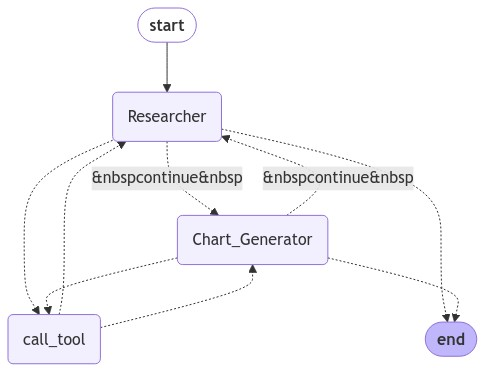

In [17]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")


### 9. 执行工作流

接下来我们将执行多智能体构建的工作流，最终生成一些统计图表。

================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then plot a line chart with Python. End the task after generating the chart。
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_4bNHw8xmddvPxi9h1MRL63Bm)
 Call ID: call_4bNHw8xmddvPxi9h1MRL63Bm
  Args:
    query: United States GDP data from 2000 to 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.statista.com/topics/772/gdp/", "content": "U.S. gross domestic product contributions 2000-2021, by sector\nValue added to gross domestic product across economic sectors in the United States from 2000 to 2021 (as a share of GDP)\nU.S. change in real value added to GDP 2022, by industry\nChange in real value added to the gross domestic product of the United States in 2022, 

Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Name: Chart_Generator
Tool Calls:
  python_repl (call_UIZImnm3cwMYjIvX8W4H0JE5)
 Call ID: call_UIZImnm3cwMYjIvX8W4H0JE5
  Args:
    code: import matplotlib.pyplot as plt

years = list(range(2000, 2021))
gdp_values = [10250.1, 10580.5, 10580.4, 10863.0, 11168.4, 11433.2, 11855.0, 12321.1, 14720.0, 14418.7, 14964.4, 15517.9, 16156.0, 16785.0, 17525.0, 18206.0, 18707.0, 19485.0, 20580.0, 21433.2, 21060.5]

plt.figure(figsize=(10, 5))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP of the United States (2000-2020)')
plt.xlabel('Year')
plt.ylabel('GDP in Billion Dollars')
plt.xticks(years, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


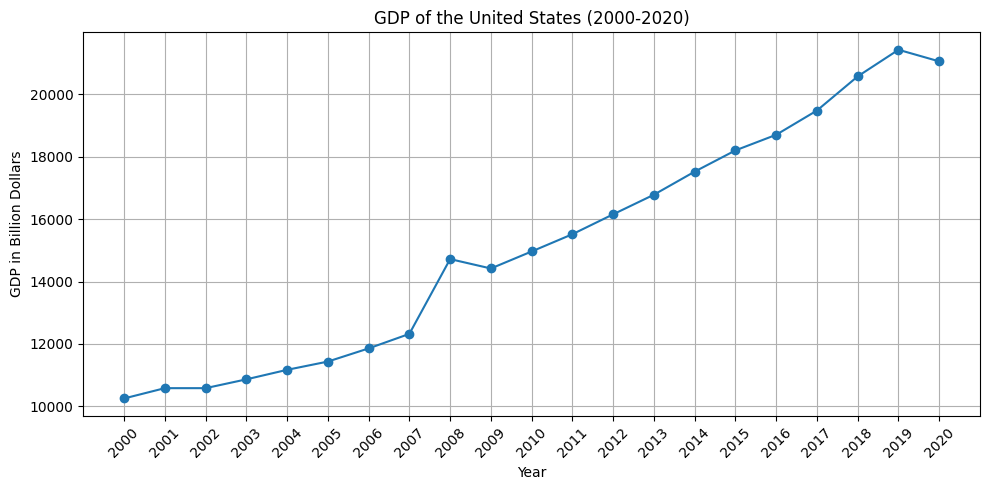

================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python
import matplotlib.pyplot as plt

years = list(range(2000, 2021))
gdp_values = [10250.1, 10580.5, 10580.4, 10863.0, 11168.4, 11433.2, 11855.0, 12321.1, 14720.0, 14418.7, 14964.4, 15517.9, 16156.0, 16785.0, 17525.0, 18206.0, 18707.0, 19485.0, 20580.0, 21433.2, 21060.5]

plt.figure(figsize=(10, 5))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP of the United States (2000-2020)')
plt.xlabel('Year')
plt.ylabel('GDP in Billion Dollars')
plt.xticks(years, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
```

================================== Ai Message ==================================
Name: Chart_Generator

FINAL ANSWER

The line chart displaying the GDP of the United States from 2000 to 2020 has been successfully generated. If you have any further questions or need additional assistance, feel free to ask!


In [18]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Obtain the GDP of the United States from 2000 to 2020, "
            "and then plot a line chart with Python. End the task after generating the chart。"
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容


## Homework

1. 使用不同的大模型运行多智能体，对比结果并评选 `gpt-4o` 之下最好的大模型，将所有的大模型和最终结果生成一张表格；
2. 将 `Chart_Generator` 替换为其他功能智能体（如 `table_generator`），为其设计提示词，然后运行查看生成结果。
3. [**可选**]优化研究智能体 `Researcher` 提示词和路由函数 `route` 跳转逻辑，提升图表生成的成功率。